<a href="https://colab.research.google.com/github/akanksharai0407/deep_fashion_classifier/blob/main/deep_fashion_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the necessary libraries

In [ ]:
!pip install kagglehub seaborn
import os
import pandas as pd
import numpy as np
import PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, recall_store,classification_report
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchvision import models




# Data overview

In [ ]:
# Download dataset
import kagglehub
path = kagglehub.dataset_download("vikashrajluhaniwal/fashion-images")

# Download CSV
data = pd.read_csv(path + '/data/fashion.csv')
print("Column names", data.columns.tolist())
print(data.head())

100%|██████████| 335M/335M [00:03<00:00, 99.2MB/s]

Extracting files...


Column names ['ProductId', 'Gender', 'Category', 'SubCategory', 'ProductType', 'Colour', 'Usage', 'ProductTitle', 'Image', 'ImageURL']
   ProductId Gender Category SubCategory ProductType Colour   Usage  \
0      42419  Girls  Apparel     Topwear        Tops  White  Casual   
1      34009  Girls  Apparel     Topwear        Tops  Black  Casual   
2      40143  Girls  Apparel     Topwear        Tops   Blue  Casual   
3      23623  Girls  Apparel     Topwear        Tops   Pink  Casual   
4      47154  Girls  Apparel  Bottomwear      Capris  Black  Casual   

                                  ProductTitle      Image  \
0           Gini and Jony Girls Knit White Top  42419.jpg   
1                Gini and Jony Girls Black Top  34009.jpg   
2  Gini and Jony Girls Pretty Blossom Blue Top  40143.jpg   
3   Doodle Kids Girls Pink I love Shopping Top  23623.jpg   
4             Gini and Jony Girls Black Capris  47154.jpg   

                                            ImageURL  
0  http://assets

Find the unique values of each columns and also count of each value in categorical columns to understand is the data balanced or not


In [ ]:
## Image filtering and distribution visualization

def make_path(row):
    return os.path.join(path, 'data', roe['Category'], row['Gender'],
                      'Images', 'images_with_product_ids', row['Image'])

data['full_path']= data.apply(make_path, axis=1)
data = dat[data['full_path'].apply(os.path.exists)].reset_index(drop=True)
print(f"Images found: {len(data)}")

print("Number of unique values":)
print(f"- Category: {data['Category'].nunique}")
print(f"- SubCategory: {data['SubCategory'].nunique}")
print(f"- ProductType: {data['ProductType'].nunique}")

# Output of the distribution by category

def display_valie_columns(column_name):
    counts = data[column_name].value_counts().reset_index()
    counts.columns= [column_name, 'Quantity']
    print(f"\nDistribution by '{column_namw}':")
    display(counts)

# Output
display_value_counts('Category') display_value_counts('Category')

Images found: 2906
Number of unique values:
- Category: 2
- SubCategory: 9
- ProductType: 31

Distribution by 'Category':


,Category,Quantity
0,Footwear,1580
1,Apparel,1326


In [ ]:
print(data['ProductType'].unique())

['Tops' 'Capris' 'Dresses' 'Shorts' 'Tshirts' 'Skirts' 'Jeans' 'Leggings'
 'Innerwear Vests' 'Rompers' 'Lehenga Choli' 'Salwar' 'Booties'
 'Clothing Set' 'Trousers' 'Shirts' 'Jackets' 'Kurtas' 'Sweatshirts'
 'Kurta Sets' 'Churidar' 'Waistcoat' 'Blazers' 'Casual Shoes' 'Flip Flops'
 'Sandals' 'Formal Shoes' 'Sports Shoes' 'Sports Sandals' 'Flats' 'Heels']


# Data preprocessing

For further training of models, we chose the Product type category.

In [ ]:
# Calculating the quantity by category

category_counts= data['ProductType'].value_counts()

# Filtering categories that have at least 50 images
filtered_categories = category_counts[category_counts >=50]
desired = filtered_categories.index.tolist()

# Filtering
filtered_df = data[data['ProductType'].isin(desired)].reset_index(drop=True)
print(f" Filtered {len(desired)} category:")
print(filtered_df['ProductType'].value_counts())


 Filtered 12 category:
ProductType
Tshirts         637
Casual Shoes    403
Heels           348
Sports Shoes    341
Tops            229
Flip Flops      150
Flats           138
Sandals         107
Shorts           91
Shirts           79
Formal Shoes     76
Dresses          74
Name: count, dtype: int64


In [ ]:
Here we can see visualized examples of each ProductType

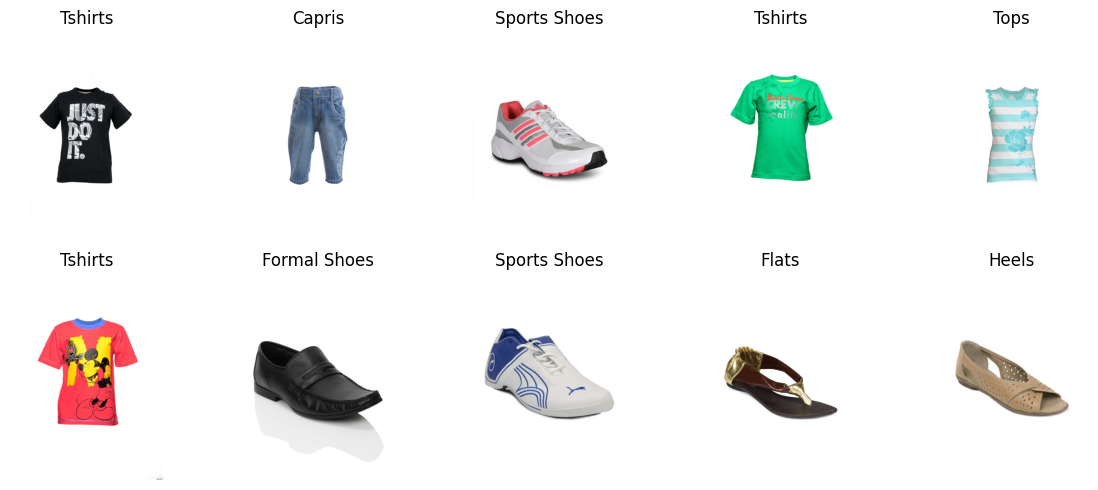

In [ ]:
classes = sorted(data['ProductType'].unique())

# Pick 10 random indices
num_samples = 10
random_indices= random.sample(range(len(data)), num_samples)
fig, axes = plt.subplots(2,5, figsize=(12,5))
for i, idx in enumerate(random_indices):
    row= data.iloc[idx]
    img= Image.open(row['full_path']).convert('RGB')
    ax= axes[i//5, i%5]
    ax.imshow(img)
    ax.set_title(row['ProductType'])
    ax.axis('off')
plt.tight_layout()
plt.show()

Encoding of class labels

In [ ]:
encoder = LabelEncoder()
filtered_df['label'] = encoder.fit_transform(filtered_df['ProductType'])
num_classes = len(encoder.classes_)
print("Classes:", encoder.classes_)

Classes: ['Casual Shoes' 'Dresses' 'Flats' 'Flip Flops' 'Formal Shoes' 'Heels'
 'Sandals' 'Shirts' 'Shorts' 'Sports Shoes' 'Tops' 'Tshirts']


Splitting data into train/val/test

In [ ]:
train_val_df, test_df = train_test_split(filtered_df, test_size=0.10, stratify=filtered_df['label'], random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.2222, stratify=train_val_df['label'], random_state=42)
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Train: 1870, Val: 535, Test: 268


# Model setup and data preparation

Setting up hyperparameters and basic transformation of images to feed into the model

In [ ]:
# Hyperparameters
BATCH_SIZE = 128
LEARNING_RATE = 0.001
EPOCHS = 10

# Data Preparation
tfms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])])

Creating Dataset and DataLoader

In [ ]:
class FashionDataset(Dataset):
     def __init__(self, df, transforms=None)
         self.df = df.reset_index(drop=True)
         self.transforms= transforms

     def __len__(self):
         return len(self.df)

     def __getitem__(self, idx):
         row = self.df.iloc[idx]
         img = Image.open(row['full_path']).convert('RGB')
         if self.transforms:
            img = self.transforms(img)
         return img, row['label']

train_loader = DataLoader(FashionDataset(train_df, transforms=tfms), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(FashionDataset(val_df, transforms=tfms), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(FashionDataset(test_df, transforms=tfms), batch_size=BATCH_SIZE, shuffle=False)

# CNN model definition and training

In [ ]:
class CNN(nn.Module):
     def __init__(self,num_classes):
         super(CNN, self).__init__()
         self.conv1= nn.Conv2d(3, 32, 3, padding=1)
         self.conv2= nn.Conv2d(32, 64, 3, padding=1)
         self.dropout1 = nn.Dropout(0.25)
         self.dropout2 = nn.Dropout(0.5)
         self.fc1 = nn.Linear(64*64*64, 128)
         self.fc2 = nn.Linear(128,num_classes)

     def forward(self, x):
         x = F.relu(self.conv1(x))
         x = F.relu(self.conv2(x))
         x = F.max_pool2d(x, 2)
         x = self.dropout1(x)
         x = torch.flatten(x, 1)
         x = F.relu(self.fc1(x))
         x = self.dropout2(x)
         x = self.fc2(x)
         return x

In [ ]:
model = CNN(num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr= LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

history = {"Loss": [], "Val Loss": [], "Accuracy": [], "Val Accuracy": []}
pbar = tqdm(range(EPOCHS))

for _ in pbar:
    model.train()
    total, correct, running_loss=0,0,0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs= model(imgs)
        loss= criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()*imgs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0,0,0
    with torch.no_grad():
         for imgs, labels in val_loader:
             imgs, labels = imgs.to(device), labels.to(device)
             outputs = model(imgs)

              val_loss += criterion(outputs, labels).item()*imgs.size(0)
              val_correct += (outputs.argmax(1)== labels).sum().item()
              val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total

    #Logging
    history["Loss"].append(train_loss)
    history["Val Loss"].append(val_loss)
    history["Accuracy"].append(train_acc)
    history["Val Accuracy"].append(val_acc)

    pbar.set_postfix_str(
        f"Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, "
        f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}"
    )

    print(f"Epoch {_+1}/{EPOCHS} - "
          f"Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 - Loss: 12.7891, Accuracy: 0.1893, Val Loss: 2.1381, Val Accuracy: 0.3178
Epoch 2/10 - Loss: 1.8295, Accuracy: 0.4230, Val Loss: 1.3493, Val Accuracy: 0.5645
Epoch 3/10 - Loss: 1.2238, Accuracy: 0.5791, Val Loss: 0.9608, Val Accuracy: 0.6542
Epoch 4/10 - Loss: 0.8781, Accuracy: 0.6850, Val Loss: 0.8679, Val Accuracy: 0.6860
Epoch 5/10 - Loss: 0.6656, Accuracy: 0.7631, Val Loss: 0.7583, Val Accuracy: 0.7215
Epoch 6/10 - Loss: 0.5539, Accuracy: 0.8037, Val Loss: 0.7624, Val Accuracy: 0.7383
Epoch 7/10 - Loss: 0.4548, Accuracy: 0.8492, Val Loss: 0.7500, Val Accuracy: 0.7458
Epoch 8/10 - Loss: 0.3783, Accuracy: 0.8701, Val Loss: 0.7464, Val Accuracy: 0.7607
Epoch 9/10 - Loss: 0.2902, Accuracy: 0.8995, Val Loss: 0.7795, Val Accuracy: 0.7551
Epoch 10/10 - Loss: 0.2325, Accuracy: 0.9209, Val Loss: 0.7855, Val Accuracy: 0.7738


**Model evaluation**

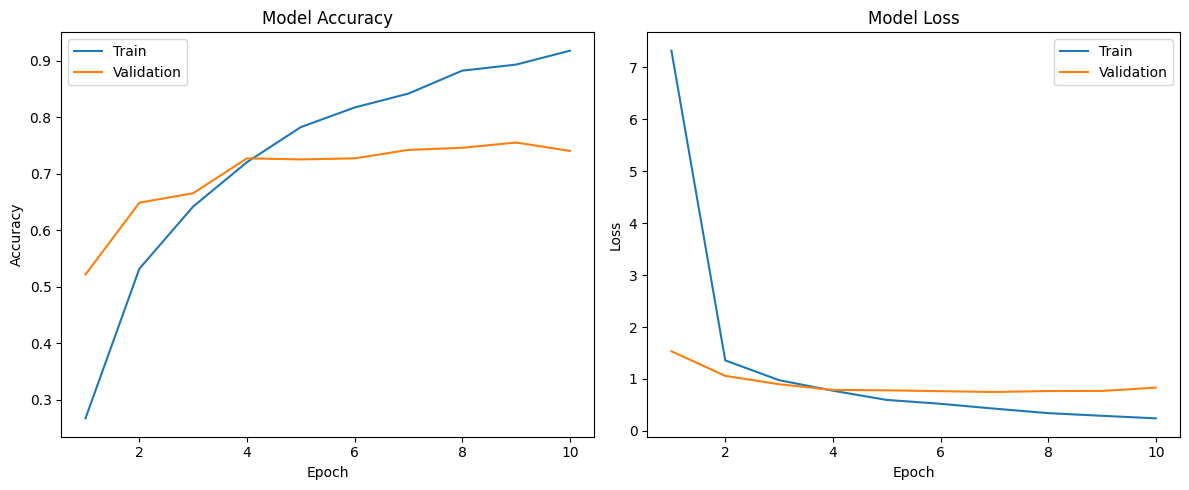

In [ ]:
# Accuracy and Loss curves
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(range(1, EPOCHS+1), history["Accuracy"], label='Train')
plt.plot(range(1, EPOCHS+1), history["Val Accuracy"], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(range(1,EPOCHS+1), history["Loss"], label='Train')
plt.plot(range(1,EPOCHS+1), history["Val Loss"], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

**Quantitative results:**

Test Accuracy: 70.5224%


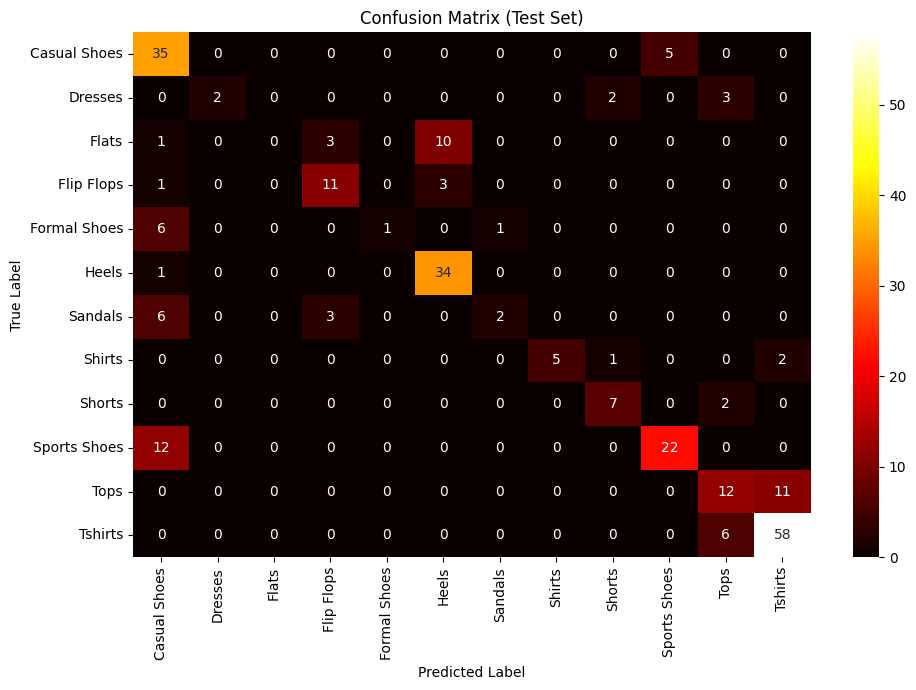

In [ ]:
# Testing model
big_test_loader = DataLoader(FashionDataset(test_df, transforms=tfms), batch_size=len(test_df), shuffle=False)

testImgs, testLabels = next(iter(big_test_loader))
testImgs = testImgs.to(device)
testLabels = testLabels.to(device)

# Forward pass
model.eval()
with torch.no_grad():
     out = model(testImgs)
     preds = out.argmax(1)

# Accuracy
acc = accuracy_score(testLabels.cpu(), preds.cpu()) * 100
print(f"Test Accuracy: {acc:.4f}%")

# Confusion Matrix
cm = confusion_matrix(testLabels.cpu(), preds.cpu())

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="hot",
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()


In [ ]:
#  Classification Report : Precision, Recall, F1-score
print("Classification Report for CNN model:")
print(classification_report(testLabels.cpu(), preds.cpu(), target_names=encoder.classes_))


Classification Report for CNN model:
              precision    recall  f1-score   support

Casual Shoes       0.56      0.88      0.69        40
     Dresses       1.00      0.29      0.44         7
       Flats       0.00      0.00      0.00        14
  Flip Flops       0.65      0.73      0.69        15
Formal Shoes       1.00      0.12      0.22         8
       Heels       0.72      0.97      0.83        35
     Sandals       0.67      0.18      0.29        11
      Shirts       1.00      0.62      0.77         8
      Shorts       0.70      0.78      0.74         9
Sports Shoes       0.81      0.65      0.72        34
        Tops       0.52      0.52      0.52        23
     Tshirts       0.82      0.91      0.86        64

    accuracy                           0.71       268
   macro avg       0.70      0.55      0.56       268
weighted avg       0.69      0.71      0.67       268



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Top-5 predicted classes (CNN):
[11] Tshirts              (52.10%)
[7] Shirts               (18.08%)
[10] Tops                 (12.91%)
[8] Shorts               (4.25%)
[1] Dresses              (4.13%)


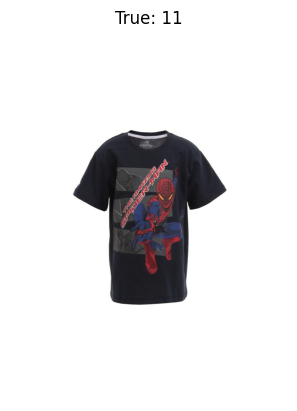

In [ ]:
# Pick one random image from test set
sample_row = test_df.sample(1).iloc[0]
img_path = sample_row['full_path']
true_label = sample_row['label']

# Load and preprocess image
img = Image.open(img_path).convert("RGB")
img_tensor = tfms(img).unsqueeze(0).to(device)

# Forward pass through CNN
model.eval()
with torch.no_grad():
     outputs = model(img_tensor)
     probs = torch.softmax(outputs, dim=1).squeeze()

# Get top-5 predictions
topk_indices = torch.topk(probs, 5).indices.tolist()

print("Top-5 predicted classes (CNN):")
for idx in topk_indices:
    prob = probs[idx].item()
    print(f"[{idx}] {encoder.classes_[idx]:20} ({prob * 100:.2f}%)")

# Show image with true label
plt.imshow(img)
plt.title(f"True: {true_label}")
plt.axis("off")
plt.show()


# ResNet model definition and training

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_resnet = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, num_classes)
model_resnet = model_resnet.to(device)

optimizer = optim.Adam(model_resnet.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

#Training
model_resnet.train()

history = {
    "train_loss": [],
    "train_acc": []
}
for epoch in range(EPOCHS):
    epoch_loss, correct, total = 0.0, 0, 0
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}")

    for i, (x, y) in pbar:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model_resnet(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * x.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

        pbar.set_postfix(loss=loss.item(), acc=correct/total)

        # Validation
model_resnet.eval()
val_loss, val_correct, val_total = 0.0, 0, 0
with torch.no_grad():
     for x_val, y_val in val_loader:
         x_val, y_val = x_val.to(device), y_val.to(device)
         val_outputs = model_resnet(x_val)
         val_loss += criterion(val_outputs, y_val).item()*x_val.size(0)
         val_preds = val_outputs.argmax(dim=1)
         val_correct += (val_preds == y_val).sum().item
         val_total += y_val.size(0)

val_loss /= val_total
val_acc = val_correct / val_total

print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {epoch_loss/total:.4f}, Accuracy: {correct/total:.4f}, "
      f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")



history.setdefault("val_loss", []).append(val_loss)
history.setdefault("val_acc", []).append(val_acc)

model_resnet.train()

print(f"Epoch {epoch+1}: Loss = {epoch_loss/total:.4f}, Accuracy = {correct/total:.4f}")
history["train_loss"].append(epoch_loss / total)
history["train_acc"].append(correct / total)


Epoch 1:   0%|          | 0/15 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Accuracy curve
plt.plot(history["train_acc"], label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("ResNet Train Accuracy")
plt.legend()
plt.show()

# Loss curve
plt.plot(history["train_loss"], label="Train Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ResNet Train Loss")
plt.legend()
plt.show()

Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Test Loss: 0.9431, Test Accuracy: 0.7500

Classification Report:
               precision    recall  f1-score   support

Casual Shoes       0.81      0.75      0.78        40
     Dresses       1.00      0.86      0.92         7
       Flats       0.20      0.14      0.17        14
  Flip Flops       0.88      0.93      0.90        15
Formal Shoes       0.70      0.88      0.78         8
       Heels       0.67      0.80      0.73        35
     Sandals       1.00      0.91      0.95        11
      Shirts       0.73      1.00      0.84         8
      Shorts       0.90      1.00      0.95         9
Sports Shoes       0.88      0.82      0.85        34
        Tops       0.46      0.91      0.61        23
     Tshirts       1.00      0.59      0.75        64

    accuracy                           0.75       268
   macro avg       0.77      0.80      0.77       268
weighted avg       0.80      0.75      0.75       268



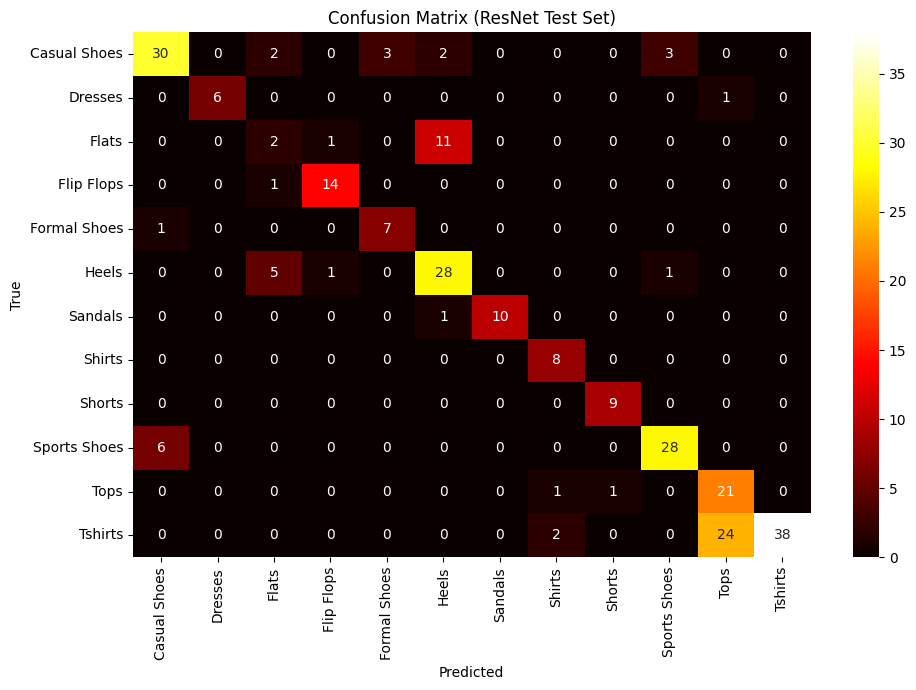

Test Accuracy: 75.0000%


In [ ]:
# Evaluation on test set
model_resnet.eval()
y_true, y_pred = [],[]
test_loss, correct = 0.0,0

with torch.no_grad():
     pbar = tqdm(enumerate(test_loader), total=len(test_loader), desc="Evaluation")

    for i, (x, y) in pbar:
        x, y = x.to(device), y.to(device)
        outputs = model_resnet(x)
        loss = criterion(outputs, y)
        test_loss += loss.item() * x.size(0)

        preds = outputs.argmax(dim=1)
        correct += (preds == y).sum().item()

        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Metrics
test_loss /= len(test_loader.dataset)
test_acc = correct / len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Classification Report
from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="hot",
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (ResNet Test Set)")
plt.tight_layout()
plt.show()


# ViT model definition and training

In [ ]:
VIT_BATCH_SIZE = 64

#dataloader
vit_train_loader = DataLoader(FashionDataset(train_df, transforms=tfms), batch_size=VIT_BATCH_SIZE, shuffle=True)
vit_val_loader = DataLoader(FashionDataset(val_df,   transforms=tfms), batch_size=VIT_BATCH_SIZE, shuffle=False)
vit_test_loader = DataLoader(FashionDataset(test_df,  transforms=tfms), batch_size=VIT_BATCH_SIZE, shuffle=False)


In [ ]:
# ViT
class Patch(nn.Module):
    def __init__(self, patch_size, dim, channels=3):
        super().__init__()

        self.dim = dim
        patches = (128 // patch_size) ** 2
        self.patchify = nn.Conv2d(channels, dim, kernel_size=patch_size, stride=patch_size)
        self.pos_embedding = nn.Parameter(torch.randn(1, patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))

    def forward(self, x):
         x = self.patchify(x)
         batch_size, channels, _, _ = x.shape
         x = x.reshape(batch_size, channels, -1).transpose(-1, -2)

         cls = self.cls_token.expand(batch_size, 1, self.dim)
         x = torch.cat([cls, x], dim=1)
         x = x + self.pos_embedding
         return x

In [ ]:
#  FeedForward Layer
class FeedForward(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.feedforward = nn.Sequential(
            nn.Linear(in_dim, in_dim),
            nn.GELU(),
            nn.Linear(in_dim, out_dim)
        )

    def forward(self, x):
        return self.feedforward(x)

In [ ]:
class SelfAttn(nn.Module):
    def __init__(self, scaling, in_dim, out_dim):
        super().__init__()

        self.scaling = scaling

        #- from the input embedding create the qkv
        self.qkv = nn.Linear(in_dim, out_dim)

    def forward(self, x):

        #- create Q, K, V
        x = x.reshape(1, *x.shape).expand(3, *x.shape)
        Q, K, V = self.qkv(x)

        #- Compute self attention as described above
        return torch.softmax((Q@K.permute(0,2,1))*self.scaling, dim=-1)@V

In [ ]:
class MultiHeadSelfAttn(nn.Module):
    def __init__(self, in_dim, heads):
        super().__init__()

        out_dim = in_dim//heads
        scaling = out_dim**-0.5

        self.heads = nn.ModuleList([SelfAttn(scaling, in_dim, out_dim) for _ in range(heads)])
        self.linear = nn.Linear(in_dim, in_dim, bias=False)

    def forward(self, x):
        out_heads = [head(x) for head in self.heads]
        x = torch.concatenate(out_heads, dim=-1)
        x = self.linear(x)

        return x

In [ ]:
#  ViT Block
class ViTBlock(nn.Module):
    def __init__(self, dim, heads):
        super().__init__()
        self.ln_before = nn.LayerNorm(dim)
        self.msa = MultiHeadSelfAttn(in_dim=dim, heads=heads)

        self.ln_after = nn.LayerNorm(dim)
        self.feedforward = FeedForward(dim, dim)


    def forward(self, x):

        out_ln_before = self.ln_before(x)
        out_msa = self.msa(out_ln_before)

        x = out_msa+x

        out_ln_after = self.ln_after(x)
        out_ffd = self.feedforward(out_ln_after)

        return out_ffd + x

class ViTBase(nn.Module):
    def __init__(self, dim, patch_size, depth, heads, channels=3):
        super().__init__()
        self.patch = Patch(patch_size, dim, channels)
        self.vit_blocks = nn.ModuleList([
            ViTBlock(dim=dim, heads=heads) for _ in range(depth)])

    def forward(self, x):
        x = self.patch(x)
        for block in self.vit_blocks:
            x = block(x)
        return x

class ViTClassifier(nn.Module):
    def __init__(self, vit_blocks=4, hidden_dim=128, out_dim=12, heads=4, patch_size=16):
        super().__init__()
        self.vit = ViTBase(dim=hidden_dim, patch_size=patch_size, depth=vit_blocks, heads=heads)
        self.feedforward = FeedForward(hidden_dim, out_dim)

    def forward(self, x):
        x = self.vit(x)
        cls = x[:, 0]
        x = self.feedforward(cls)
        x = torch.softmax(x, dim=-1)
        return x


In [ ]:
# Train
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 30
log_frequency = max(1,len(train_loader) // 10)

vit = ViTClassifier(vit_blocks=4, hidden_dim=128, out_dim=12, heads=4, patch_size=16)
vit = vit.to(device)
vit.train()

opt = torch.optim.Adam(vit.parameters(), lr=3e-5)


In [ ]:
def val(epoch, data, model, device=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    model.eval()
    hist_loss, hist_acc = 0, 0

    for idx, (samples, labels) in enumerate(data):
        samples = samples.to(device)
        labels = labels.to(device)

        preds = model(samples)
        loss = nn.functional.cross_entropy(preds, labels)

        max_preds = torch.argmax(preds, dim=1)
        acc = (max_preds == labels).sum() / len(labels)

        hist_loss += loss.item()
        hist_acc += acc.item()

    hist_loss /= idx
    hist_acc /= idx

    print(f"[Val {epoch}] loss: {hist_loss:.4f}, acc: {hist_acc:.4f}")
    return hist_loss, hist_acc


In [ ]:
history = {
    "train": {"acc": [0 for _ in range(epochs)], "loss": [0 for _ in range(epochs)]},
    "val":   {"acc": [0 for _ in range(epochs)], "loss": [0 for _ in range(epochs)]},
}

for epoch in range(epochs):
    vit.train()
    for idx, (samples, labels) in enumerate(train_loader):
        opt.zero_grad()
        samples = samples.to(device).type(torch.float32)
        labels = labels.to(device)

        preds = vit(samples)
        loss = nn.functional.cross_entropy(preds, labels)
        loss.backward()
        opt.step()
        max_preds = torch.argmax(preds, dim=1)
        acc = (max_preds == labels).sum() / len(labels)

        history["train"]["loss"][epoch] += loss.item()
        history["train"]["acc"][epoch]  += acc.item()


    history["train"]["loss"][epoch] /= len(train_loader)
    history["train"]["acc"][epoch]  /= len(train_loader)

    print(f"[{epoch+1}/{epochs}] avg loss: {history['train']['loss'][epoch]:.5f}, acc: {history['train']['acc'][epoch]:.5f}")
    history["val"]["loss"][epoch], history["val"]["acc"][epoch] = val(epoch+1, val_loader, vit)


[1/30] avg loss: 2.48432, acc: 0.08567
[Val 1] loss: 3.0960, acc: 0.0773
[2/30] avg loss: 2.46782, acc: 0.16453
[Val 2] loss: 3.0727, acc: 0.3015
[3/30] avg loss: 2.44507, acc: 0.23797
[Val 3] loss: 3.0359, acc: 0.3015
[4/30] avg loss: 2.41281, acc: 0.23830
[Val 4] loss: 2.9957, acc: 0.3015
[5/30] avg loss: 2.38955, acc: 0.23930
[Val 5] loss: 2.9795, acc: 0.3015
[6/30] avg loss: 2.38340, acc: 0.23897
[Val 6] loss: 2.9753, acc: 0.3015
[7/30] avg loss: 2.38030, acc: 0.24030
[Val 7] loss: 2.9740, acc: 0.3015
[8/30] avg loss: 2.38157, acc: 0.23830
[Val 8] loss: 2.9734, acc: 0.3015
[9/30] avg loss: 2.38218, acc: 0.23730
[Val 9] loss: 2.9730, acc: 0.3015
[10/30] avg loss: 2.38292, acc: 0.23630
[Val 10] loss: 2.9728, acc: 0.3015
[11/30] avg loss: 2.38024, acc: 0.23897
[Val 11] loss: 2.9726, acc: 0.3015
[12/30] avg loss: 2.38204, acc: 0.23697
[Val 12] loss: 2.9725, acc: 0.3015
[13/30] avg loss: 2.38097, acc: 0.23797
[Val 13] loss: 2.9723, acc: 0.3015
[14/30] avg loss: 2.38025, acc: 0.23864
[Va


 Test Accuracy: 31.34%


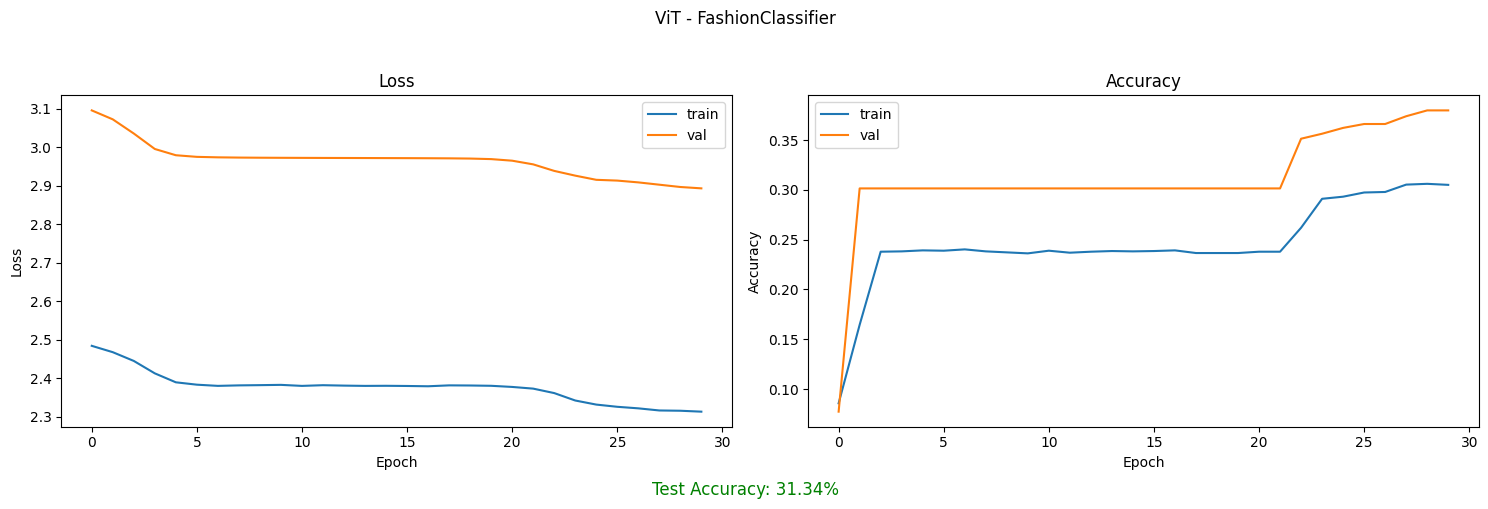

In [ ]:
vit.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        outputs = vit(imgs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = accuracy_score(all_labels, all_preds)
print(f"\n Test Accuracy: {test_acc * 100:.2f}%")

plt.figure(figsize=(15, 5))
plt.suptitle("ViT - FashionClassifier")

# loss
plt.subplot(1, 2, 1)
plt.title("Loss")
plt.plot(history["train"]["loss"], label="train")
plt.plot(history["val"]["loss"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# accuracy
plt.subplot(1, 2, 2)
plt.title("Accuracy")
plt.plot(history["train"]["acc"], label="train")
plt.plot(history["val"]["acc"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.figtext(0.5, 0.01, f"Test Accuracy: {test_acc * 100:.2f}%", ha="center", fontsize=12, color="green")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


2 experiment with adjusted the hyperparameters: reduced learning rate to 3e-5, used Dropout , increased layer to 6

In [ ]:
!pip install vit-pytorch
from vit_pytorch import ViT

class FeedForward(nn.Module):
    def __init__(self, in_dim, out_dim, dropout=0.1):
        super().__init__()
        self.ff = nn.Sequential(
            nn.Linear(in_dim, in_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(in_dim, out_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.ff(x)

class ViTClassifier(nn.Module):
    def __init__(self, vit_blocks=6, hidden_dim=128, out_dim=12, heads=4, patch_size=16):
        super().__init__()
        self.vit = ViT(image_size=128, patch_size=patch_size, num_classes=hidden_dim,
                       dim=hidden_dim, depth=vit_blocks, heads=heads, mlp_dim=hidden_dim)
        self.feedforward = FeedForward(hidden_dim, out_dim)

    def forward(self, x):
        cls = self.vit(x)
        return self.feedforward(cls)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.8/140.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 880.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-c

In [ ]:
from torch.optim import Adam

def val(epoch, data, model, device):
    model.eval()
    loss_fn = nn.CrossEntropyLoss()
    val_loss, val_acc = 0, 0

    for samples, labels in data:
        samples, labels = samples.to(device), labels.to(device)
        preds = model(samples)
        loss = loss_fn(preds, labels)
        acc = (preds.argmax(1) == labels).sum().item() / len(labels)
        val_loss += loss.item()
        val_acc += acc

    return val_loss / len(data), val_acc / len(data)

vit = ViTClassifier().to(device)
optimizer = Adam(vit.parameters(), lr=3e-5)
EPOCHS = 30

history = {"train": {"acc": [], "loss": []}, "val": {"acc": [], "loss": []}}

for epoch in range(EPOCHS):
    vit.train()
    total_loss, total_acc = 0, 0

    for samples, labels in train_loader:
        samples, labels = samples.to(device), labels.to(device)
        optimizer.zero_grad()
        preds = vit(samples)
        loss = nn.CrossEntropyLoss()(preds, labels)
        loss.backward()
        optimizer.step()

        acc = (preds.argmax(1) == labels).sum().item() / len(labels)
        total_loss += loss.item()
        total_acc += acc

    avg_loss = total_loss / len(train_loader)
    avg_acc = total_acc / len(train_loader)
    val_loss, val_acc = val(epoch+1, val_loader, vit, device)

    history["train"]["loss"].append(avg_loss)
    history["train"]["acc"].append(avg_acc)
    history["val"]["loss"].append(val_loss)
    history["val"]["acc"].append(val_acc)

    print(f"[Epoch {epoch+1}/{EPOCHS}] Train Loss: {avg_loss:.4f}, Acc: {avg_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")


[Epoch 1/30] Train Loss: 2.4212, Acc: 0.2082 | Val Loss: 2.3746, Acc: 0.2412
[Epoch 2/30] Train Loss: 2.3452, Acc: 0.2281 | Val Loss: 2.3143, Acc: 0.2412
[Epoch 3/30] Train Loss: 2.3069, Acc: 0.2260 | Val Loss: 2.2765, Acc: 0.2412
[Epoch 4/30] Train Loss: 2.2769, Acc: 0.2282 | Val Loss: 2.2568, Acc: 0.2412
[Epoch 5/30] Train Loss: 2.2709, Acc: 0.2234 | Val Loss: 2.2474, Acc: 0.2412
[Epoch 6/30] Train Loss: 2.2520, Acc: 0.2284 | Val Loss: 2.2379, Acc: 0.2412
[Epoch 7/30] Train Loss: 2.2462, Acc: 0.2273 | Val Loss: 2.2295, Acc: 0.2412
[Epoch 8/30] Train Loss: 2.2435, Acc: 0.2289 | Val Loss: 2.2139, Acc: 0.2412
[Epoch 9/30] Train Loss: 2.2192, Acc: 0.2326 | Val Loss: 2.1801, Acc: 0.2412
[Epoch 10/30] Train Loss: 2.1583, Acc: 0.2574 | Val Loss: 2.0861, Acc: 0.3423
[Epoch 11/30] Train Loss: 2.0093, Acc: 0.3791 | Val Loss: 1.9253, Acc: 0.4573
[Epoch 12/30] Train Loss: 1.8927, Acc: 0.4231 | Val Loss: 1.8413, Acc: 0.4760
[Epoch 13/30] Train Loss: 1.8226, Acc: 0.4390 | Val Loss: 1.7661, Acc: 0.


Test Accuracy: 70.52%


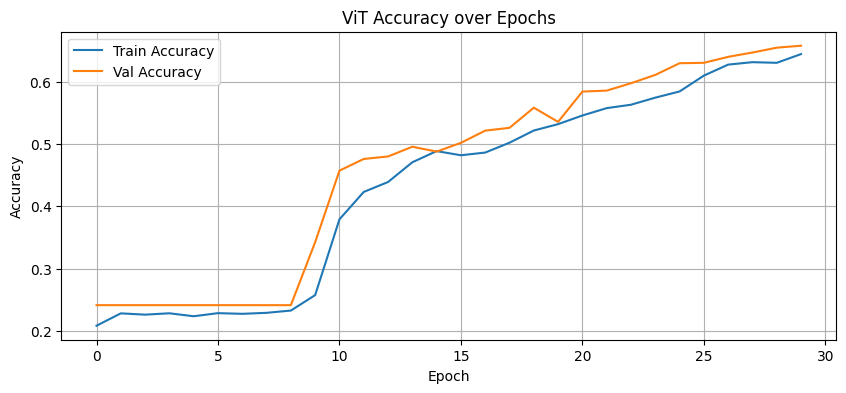

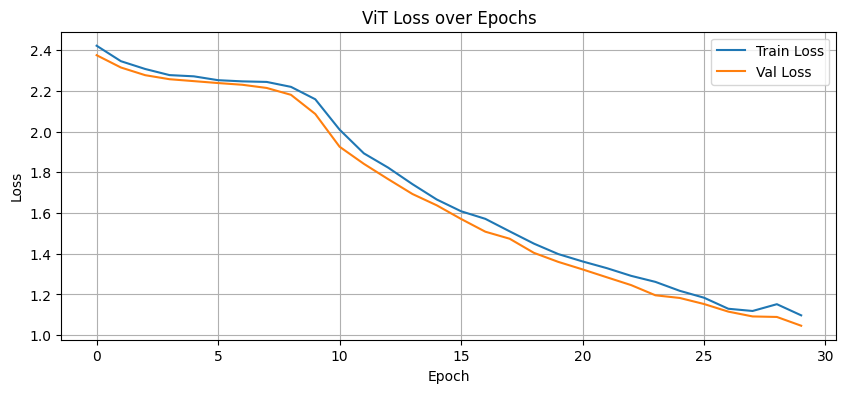

In [ ]:
vit.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vit(images)
        predicted = outputs.argmax(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_accuracy = 100 * correct / total
print(f"\nTest Accuracy: {test_accuracy:.2f}%")

# Accuracy
plt.figure(figsize=(10, 4))
plt.plot(history["train"]["acc"], label="Train Accuracy")
plt.plot(history["val"]["acc"], label="Val Accuracy")
plt.title("ViT Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.figure(figsize=(10, 4))
plt.plot(history["train"]["loss"], label="Train Loss")
plt.plot(history["val"]["loss"], label="Val Loss")
plt.title("ViT Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()



Classification Report (ViT Test Set):
              precision    recall  f1-score   support

Casual Shoes       0.43      0.72      0.54        40
     Dresses       0.00      0.00      0.00         7
       Flats       0.00      0.00      0.00        14
  Flip Flops       0.00      0.00      0.00        15
Formal Shoes       0.00      0.00      0.00         8
       Heels       0.42      0.89      0.57        35
     Sandals       0.00      0.00      0.00        11
      Shirts       0.00      0.00      0.00         8
      Shorts       0.00      0.00      0.00         9
Sports Shoes       0.00      0.00      0.00        34
        Tops       0.00      0.00      0.00        23
     Tshirts       0.51      1.00      0.67        64

    accuracy                           0.46       268
   macro avg       0.11      0.22      0.15       268
weighted avg       0.24      0.46      0.32       268



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


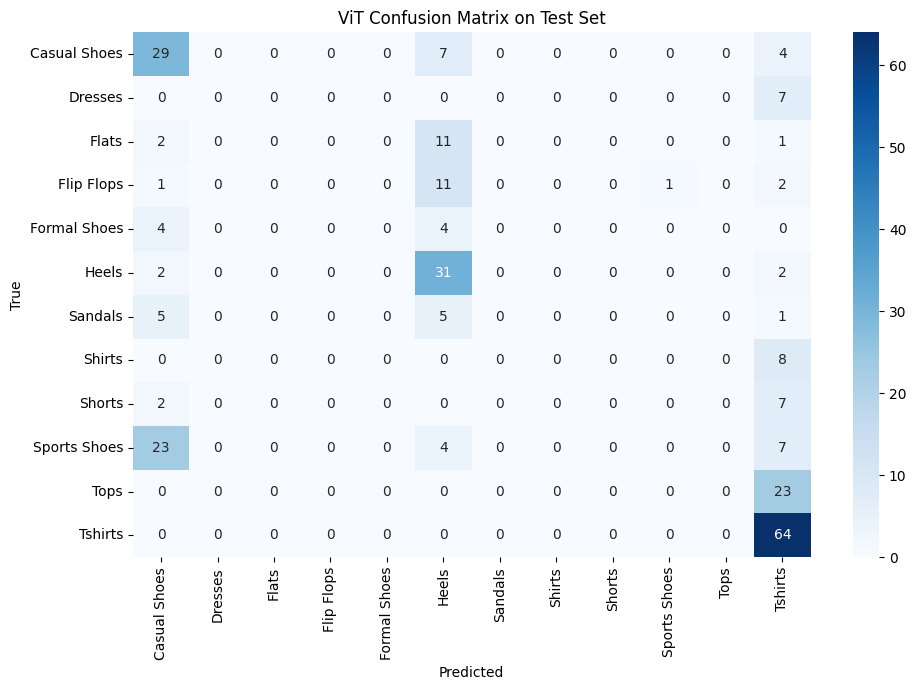

In [ ]:
vit.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vit(images)
        preds = outputs.argmax(dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\nClassification Report (ViT Test Set):")
print(classification_report(y_true, y_pred, target_names=encoder.classes_))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("ViT Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()


 Implementing top-k image predictions

Top-5 predicted classes ViT:
[5] Heels                (67.34%)
[2] Flats                (14.20%)
[3] Flip Flops           (4.02%)
[6] Sandals              (3.64%)
[0] Casual Shoes         (1.98%)


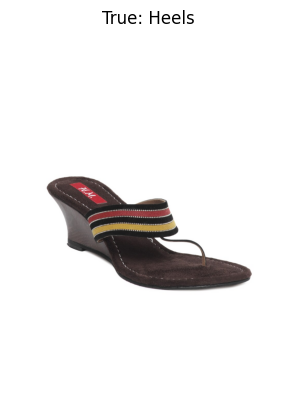

In [ ]:
#
sample_row = filtered_df.sample(1).iloc[0]
img_path = sample_row['full_path']
true_label = sample_row['ProductType']

# Load and preprocess
img = Image.open(img_path).convert("RGB")
img_tensor = tfms(img).unsqueeze(0).to(device)

# Predict top-3 classes
model = vit
model.eval()
with torch.no_grad():
    outputs = model(img_tensor).squeeze(0)

k = 5
topk_indices = torch.topk(outputs, k=k).indices.tolist()

# Show result
print("Top-5 predicted classes ViT:")
for idx in topk_indices:
    prob = torch.softmax(outputs, -1)[idx].item()
    print(f"[{idx}] {encoder.classes_[idx]:<20} ({prob * 100:.2f}%)")

# Show image with prediction
plt.imshow(img)
plt.title(f"True: {true_label}")
plt.axis("off")
plt.show()


# CLIP using

In [ ]:
!pip install git+https://github.com/openai/CLIP.git


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-tl7d57d9
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-tl7d57d9
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.8 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=f2d667d79068806648b9903c8469a05378894be29d8474d2678247f190cd2420
  Stored in directory: /tmp/pip-ephem-wheel-cache-11s227t9/wheels/3f/7c/a4/9b490845988bf7a4db33674d52f709f088f64392063872eb9a
Successfully built clip



Top-3 CLIP predictions:
a photo of a top               (3074.52%)
a photo of Tshirts             (2849.40%)
a photo of a dress             (2403.15%)


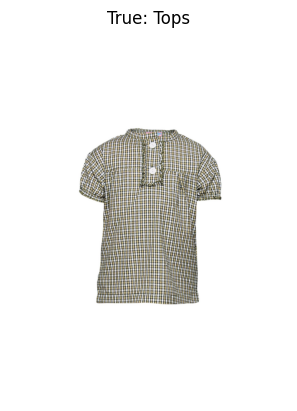

In [ ]:
import clip
import torch
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model_clip, preprocess = clip.load("ViT-B/32", device=device)

text_labels = ["a photo of a top", "a photo of a dress", "a photo of trousers",
               "a photo of heels", "a photo of sport shoes", "a photo of Tshirts"]
text_tokens = clip.tokenize(text_labels).to(device)

# Downloading random image from filtered_df
sample_row = filtered_df.sample(1).iloc[0]
img_path = sample_row['full_path']
true_label = sample_row['ProductType']

image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)

#  CLIP
with torch.no_grad():
    image_features = model_clip.encode_image(image)
    text_features = model_clip.encode_text(text_tokens)
    similarity = image_features @ text_features.T

topk = similarity[0].topk(3)
print("\nTop-3 CLIP predictions:")
for idx, score in zip(topk.indices, topk.values):
    print(f"{text_labels[idx]:<30} ({score.item()*100:.2f}%)")

plt.imshow(Image.open(img_path))
plt.title(f"True: {true_label}")
plt.axis("off")
plt.show()
